### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Load dataset 

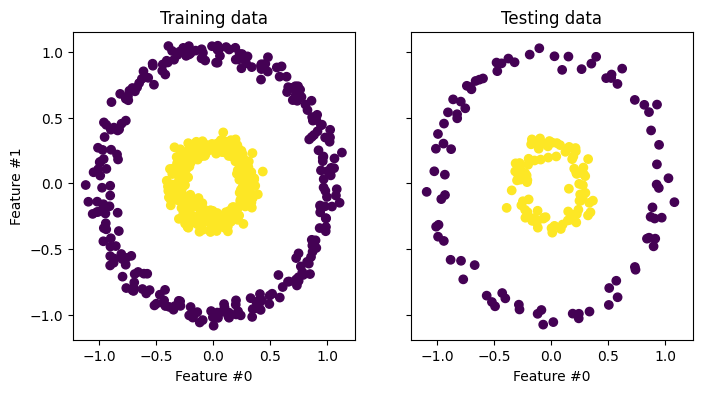

In [2]:
X, y = make_circles(n_samples=700, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

### Let's create different models by changing their hidden layers and see how they behave.

In [3]:
# 1st case: Test performance with hidden layer using ReLU as activation function.
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "relu"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
_, relu_acc = model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.3855 - acc: 0.8514


In [4]:
# 2nd case: Test performance with hidden layer using Sigmoid as activation function.
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
_, sigmoid_acc = model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.6941 - acc: 0.6400


In [5]:
# 3rd case: Test performance with hidden layer using Sigmoid as activation function (Adding 2 additional layers)
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
_,various_sigmoid_acc = model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 998us/step - loss: 0.6882 - acc: 0.6514


In [6]:
print("1st model with a ReLU as hidden layer gives an accuracy of",relu_acc)
print("2nd model with a sigmoid as hidden layer gives an accuracy of",sigmoid_acc)
print("3rd model with various sigmoid hidden layer gives an accuracy of",various_sigmoid_acc)

1st model with a ReLU as hidden layer gives an accuracy of 0.8514285683631897
2nd model with a sigmoid as hidden layer gives an accuracy of 0.6399999856948853
3rd model with various sigmoid hidden layer gives an accuracy of 0.6514285802841187


Then, we conclude that the usage of ReLU as hidden layer is proper for training our model, whereas sigmoid isn't so good. Even by adding more hidden layers, it didn't make a significant difference.

Usually, a neural network with more hidden layers should be more powerful, but it turns that we've got the `vanishing gradient problem` in this case.

In Keras, we are allowed to plug-in a callback function to the training process. We are going create our own callback object to intercept and record the weights of each layer of our multilayer perceptron (MLP) model at the end of each epoch.

We derive the *Callback* class and define the *on_epoch_end()* function. This class will need the created model to initialize. At the end of each epoch, it will read each layer and save the weights into numpy array.

In [7]:
# Illustrate weights across epochs
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)

For the convenience of experimenting different ways of creating a MLP, we make a helper function to set up the neural network model.  

We create a neural network with 4 hidden layers so we can see how each layer respond to the training. We will vary the activation function of each hidden layer as well as the weight initialization.  

We are going to name each layer instead of letting Keras to assign a name. The input is a coordinate on the xy-plane hence the input shape is a vector of 2. The output is binary classification. Therefore we use sigmoid activation to make the output fall in the range of 0 to 1.

In [8]:
def make_mlp(activation_layer):
    "Create a model with specified activation and initalizer"
    output_layer = "sigmoid"
    model = Sequential([
        Input(shape=(2,)),
        Dense(5, activation=activation_layer, kernel_initializer=RandomNormal(mean=0, stddev=1), name=activation_layer +"1"),
        Dense(5, activation=activation_layer, kernel_initializer=RandomNormal(mean=0, stddev=1), name=activation_layer +"2"),
        Dense(5, activation=activation_layer, kernel_initializer=RandomNormal(mean=0, stddev=1), name=activation_layer +"3"),
        Dense(5, activation=activation_layer, kernel_initializer=RandomNormal(mean=0, stddev=1), name=activation_layer +"4"),
        Dense(1, activation=output_layer, kernel_initializer=RandomNormal(mean=0, stddev=1), name=output_layer + "5")
    ])
    return model

What we can further look into is how the weight behaves along the iterations of training. All the layers except the first and the last are having their weight as a 5×5 matrix. We can check the mean and standard deviation of the weights to get a sense of how the weights look like.

In [9]:
def plotweight(capture_callback):
    "Plot the weights' mean and standard deviation across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
    ax[0].set_title("Mean Weight")
    for key in capture_callback.weights[0]:
        ax[0].plot(capture_callback.epochs, [w[key].mean() for w in capture_callback.weights], label=key)
    ax[0].legend()
    ax[1].set_title("Standard Deviation")
    for key in capture_callback.weights[0]:
        ax[1].plot(capture_callback.epochs, [w[key].std() for w in capture_callback.weights], label=key)
    ax[1].legend()
    plt.show()

In [10]:
batch_size = 32
n_epochs = 100

As follows we will see how the weight changes along the epochs.

Before training: Accuracy 0.5
After training: Accuracy 0.68
22/22 [==============================] - 0s 952us/step - loss: 0.6242 - acc: 0.6800
[0.6242341995239258, 0.6800000071525574]


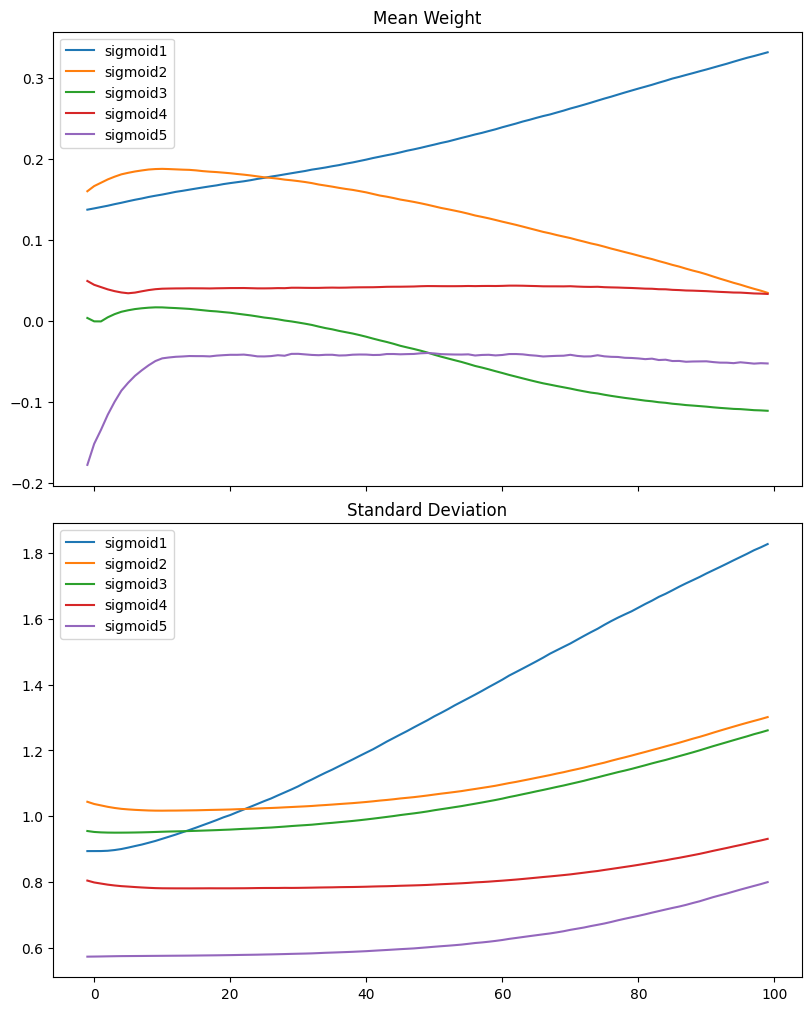

In [11]:
# Sigmoid activation
model = make_mlp("sigmoid")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
print("Before training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print("After training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
print(model.evaluate(X,y))
plotweight(capture_cb)

Before training: Accuracy 0.5014285714285714
After training: Accuracy 1.0
22/22 [==============================] - 0s 963us/step - loss: 7.5849e-06 - acc: 1.0000
[7.584853847220074e-06, 1.0]


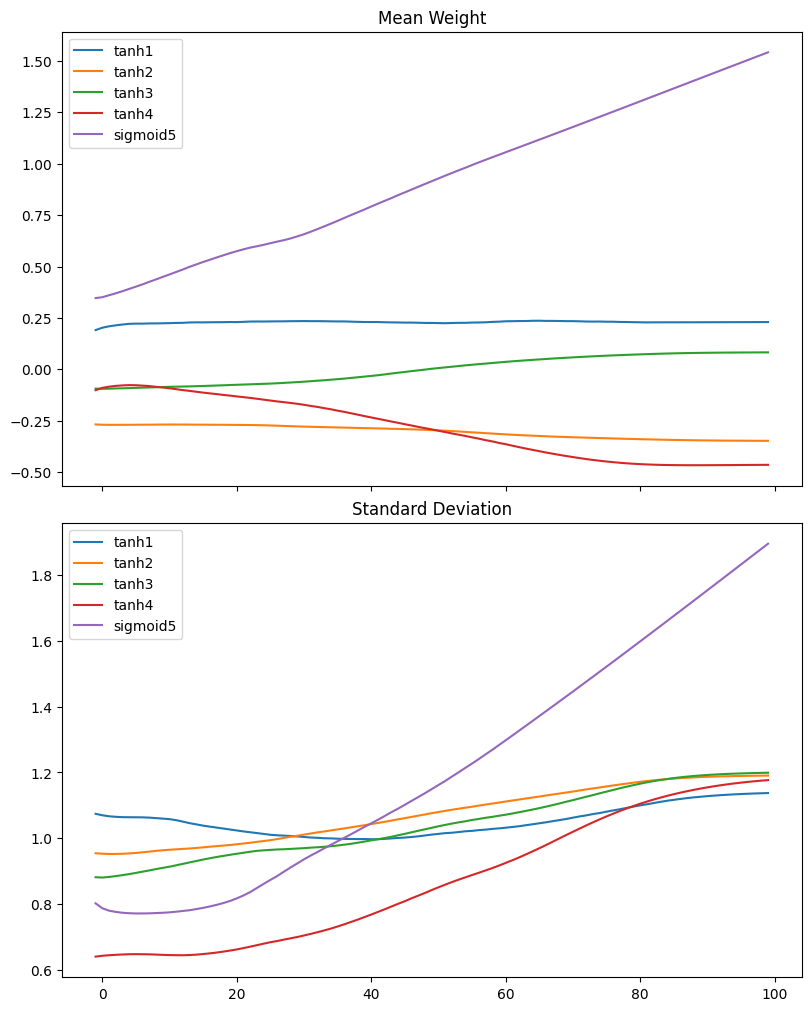

In [12]:
# tanh activation
model = make_mlp("tanh")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
print("Before training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print("After training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
print(model.evaluate(X,y))
plotweight(capture_cb)

Before training: Accuracy 0.5057142857142857
After training: Accuracy 1.0
22/22 [==============================] - 0s 1ms/step - loss: 6.0688e-09 - acc: 1.0000
[6.068767266498298e-09, 1.0]


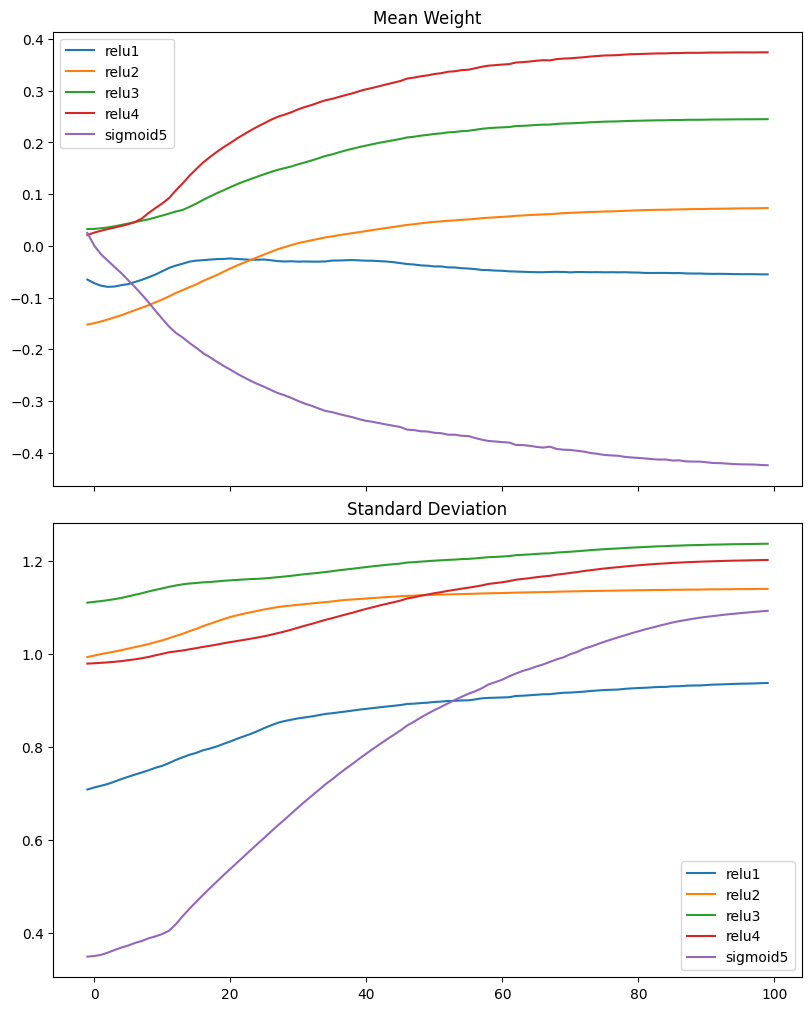

In [13]:
# relu activation
model = make_mlp("relu")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
print("Before training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print("After training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
print(model.evaluate(X,y))
plotweight(capture_cb)

### Looking at the gradients of each layer

We see the effect of different activation function in the above curves. But indeed, what matters is the gradient as we are running gradient decent during training. The paper by Xavier Glorot and Yoshua Bengio, `Understanding the difficulty of training deep feedforward neural networks`, suggested to look at the gradient of each layer in each training iteration as well as the standard deviation of it.  

To understand how the activation function related to the gradient as perceived during training, we need to run the training loop manually.  

In Tensorflow-Keras, a training loop can be run by turning on the gradient tape, and then make the neural network model produce an output, which afterwards we can obtain the gradient by automatic differentiation from the gradient tape. Subsequently we can update the parameters (weights and biases) according to the gradient descent update rule.  

Because the gradient is readily obtained in this loop, we can make a copy of it. The following is how we implement the training loop and at the same time, keep a copy of the gradients.

In [14]:
# Show gradient across epochs
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.BinaryCrossentropy()

def train_model(X, y, model, n_epochs=n_epochs, batch_size=batch_size):
    "Run training loop manually"
    train_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    gradhistory = []
    losshistory = []
    def recordweight():
        data = {}
        for g,w in zip(grads, model.trainable_weights):
            if '/kernel:' not in w.name:
                continue # skip bias
            name = w.name.split("/")[0]
            data[name] = g.numpy()
        gradhistory.append(data)
        losshistory.append(loss_value.numpy())
    for epoch in range(n_epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, y_pred)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            if step == 0:
                recordweight()
    # After all epochs, record again
    recordweight()
    return gradhistory, losshistory

In [15]:
def plot_gradient(gradhistory, losshistory):
    "Plot gradient mean and sd across epochs"
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(8, 12))
    ax[0].set_title("Mean Gradient")
    for key in gradhistory[0]:
        ax[0].plot(range(len(gradhistory)), [w[key].mean() for w in gradhistory], label=key)
    ax[0].legend()
    ax[1].set_title("Standard Deviation")
    for key in gradhistory[0]:
        ax[1].semilogy(range(len(gradhistory)), [w[key].std() for w in gradhistory], label=key)
    ax[1].legend()
    ax[2].set_title("Loss")
    ax[2].plot(range(len(losshistory)), losshistory)
    plt.show()

### Let's see how the gradient changes along the epocs

Before training: Accuracy 0.5
After training: Accuracy 0.7742857142857142


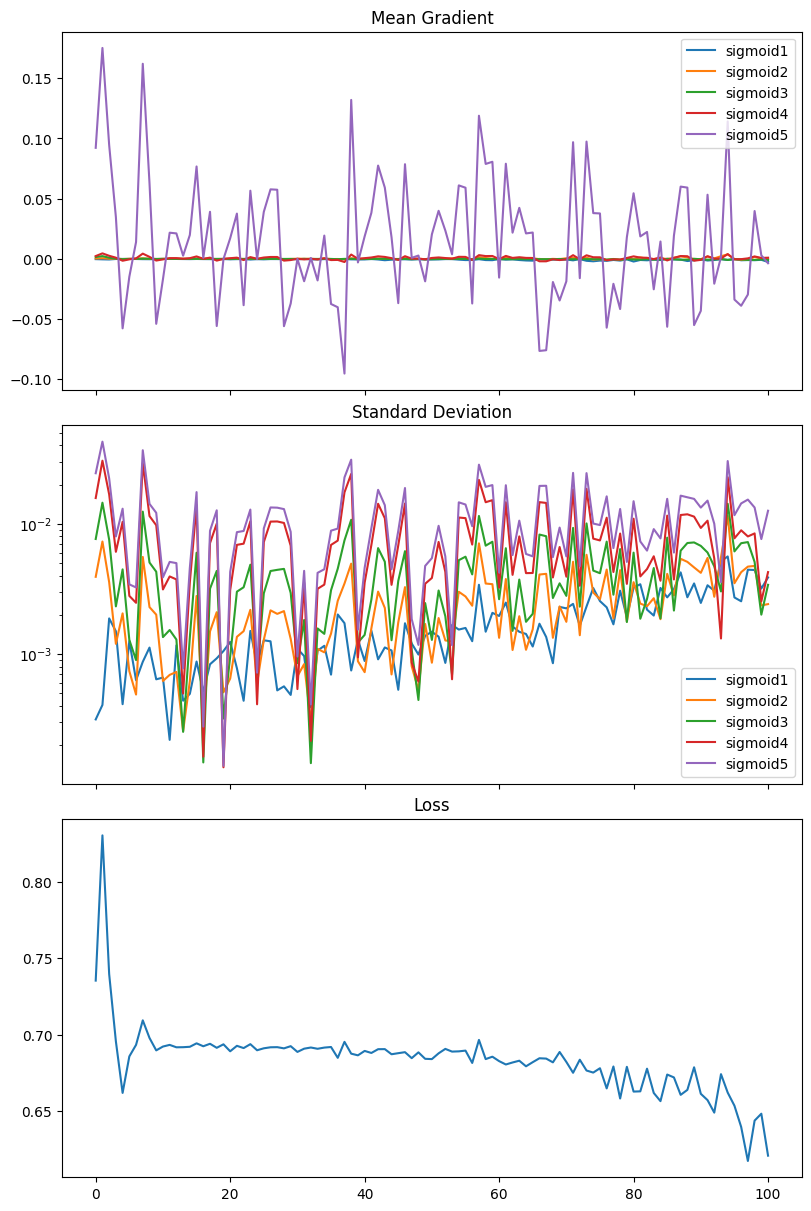

In [16]:
model = make_mlp("sigmoid")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)

Before training: Accuracy 0.51
After training: Accuracy 1.0


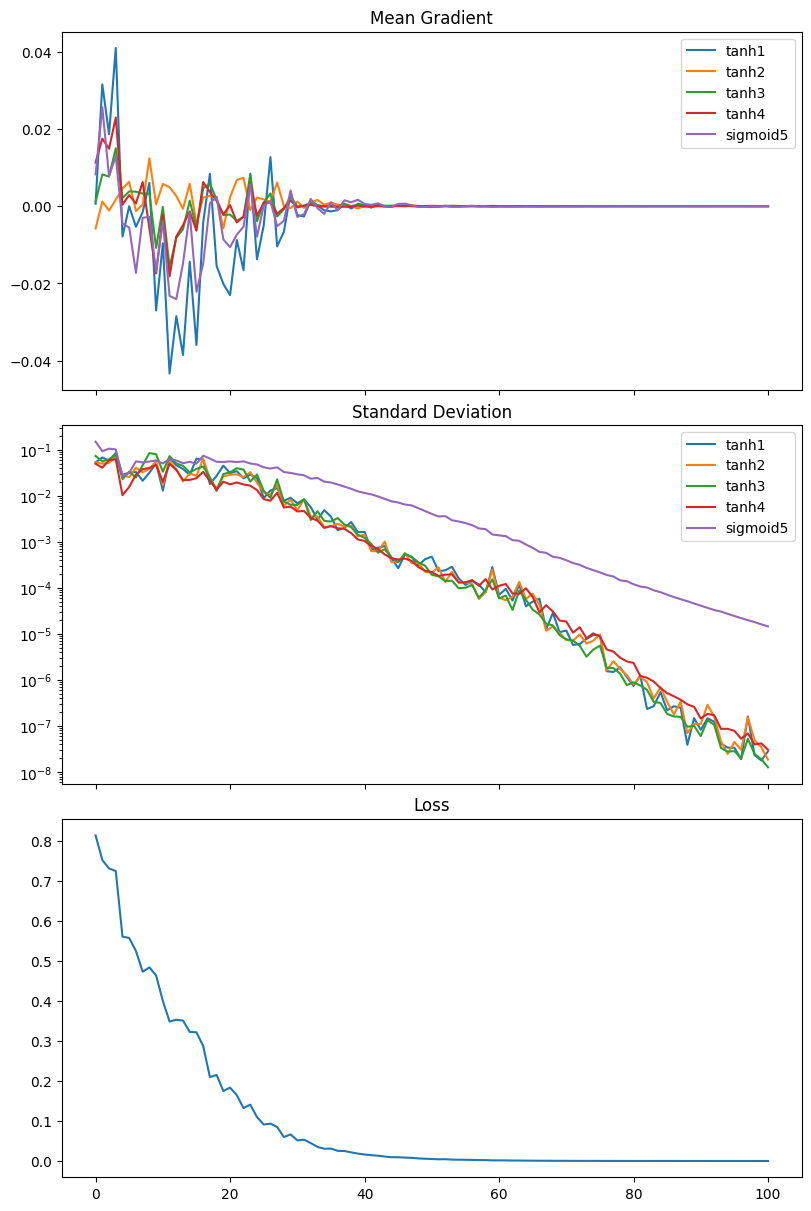

In [17]:
model = make_mlp("tanh")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)

Before training: Accuracy 0.49142857142857144
After training: Accuracy 1.0


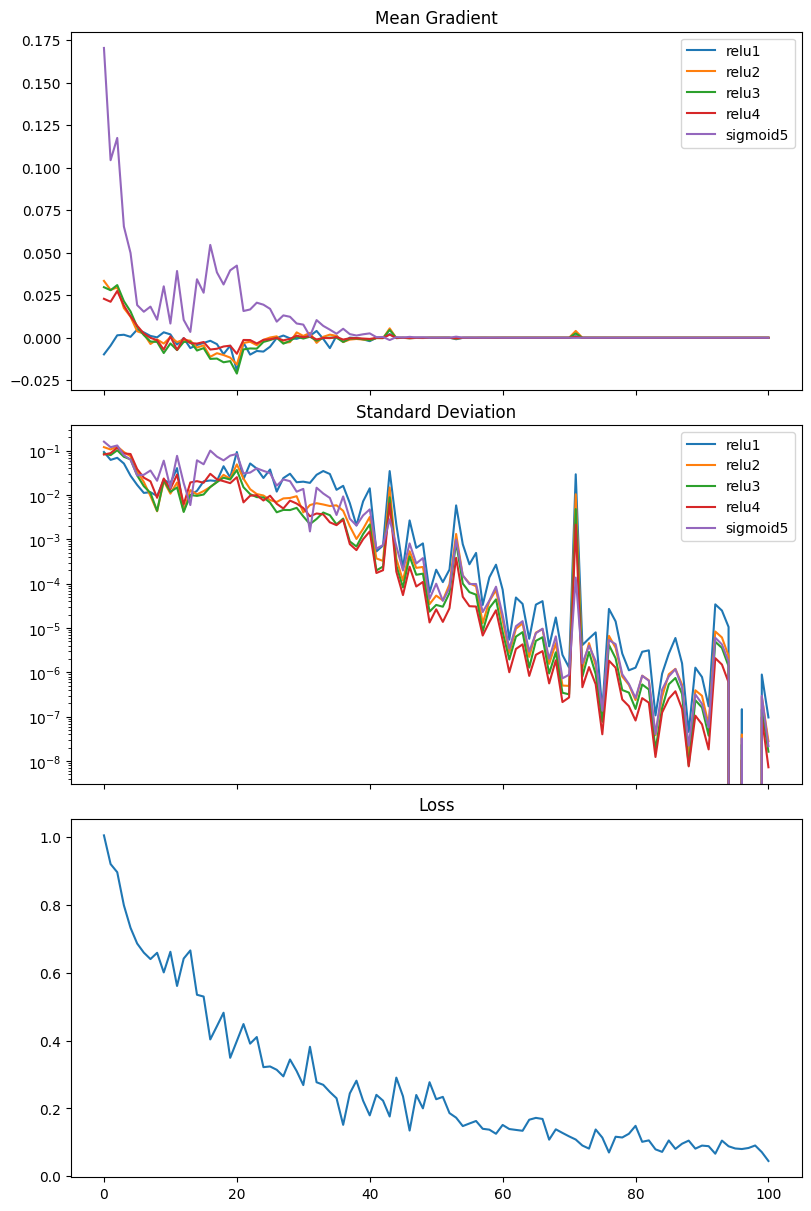

In [18]:
model = make_mlp("relu")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)